In [1]:
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
from tqdm import tqdm
import string
import pickle   # for saving trained HMMs
import os


In [2]:
# === Load and preprocess corpus ===

def load_corpus(path: str):
    with open(path, "r", encoding="utf-8") as f:
        raw = f.read().splitlines()

    # Clean words: lowercase, alphabetic only
    words = []
    for w in raw:
        w = w.strip().lower()
        # remove non-alpha chars
        w = ''.join([ch for ch in w if ch.isalpha()])
        if len(w) > 0:
            words.append(w)
    
    return words

# Load your corpus
corpus_path = "./Data/corpus.txt"
words = load_corpus(corpus_path)

print(f"✅ Loaded {len(words):,} words from corpus.")
print("Sample words:", words[:10])

✅ Loaded 50,000 words from corpus.
Sample words: ['suburbanize', 'asmack', 'hypotypic', 'promoderationist', 'consonantly', 'philatelically', 'cacomelia', 'thicklips', 'luciferase', 'cinematography']


,Word Length,Count
19,1,46
18,2,84
12,3,388
11,4,1169
9,5,2340
1,6,3755
13,7,5111
6,8,6369
2,9,6787
5,10,6465


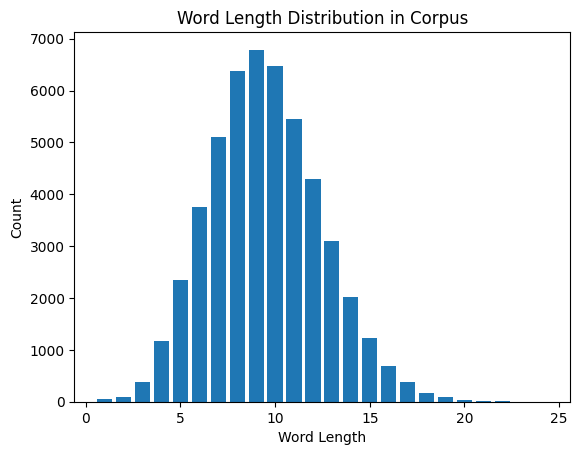

In [3]:
# Compute word length distribution
length_counts = Counter(len(w) for w in words)

df_lengths = pd.DataFrame(list(length_counts.items()), columns=["Word Length", "Count"]).sort_values("Word Length")
display(df_lengths)

# Optional: visualize if you want to see spread
try:
    import matplotlib.pyplot as plt
    plt.bar(df_lengths["Word Length"], df_lengths["Count"])
    plt.xlabel("Word Length")
    plt.ylabel("Count")
    plt.title("Word Length Distribution in Corpus")
    plt.show()
except ImportError:
    print("matplotlib not installed — skipping visualization.")


In [4]:
# === Step 4A: Prepare training sequences for each word length ===

def prepare_sequences_by_length(words):
    seqs_by_len = defaultdict(list)
    for w in words:
        L = len(w)
        seq = ['^'] + list(w) + ['$']  # add start & end tokens
        seqs_by_len[L].append(seq)
    return seqs_by_len

seqs_by_len = prepare_sequences_by_length(words)
print(f"Prepared sequences for {len(seqs_by_len)} different lengths.")
print(f"Example for length 5: {seqs_by_len[5][:5]}")


Prepared sequences for 24 different lengths.
Example for length 5: [['^', 'u', 'n', 'b', 'e', 'd', '$'], ['^', 'u', 'p', 'b', 'i', 'd', '$'], ['^', 'l', 'i', 'n', 'g', 'e', '$'], ['^', 'b', 'i', 'r', 'm', 'a', '$'], ['^', 'b', 'r', 'o', 'c', 'k', '$']]


In [5]:
# === Step 4B (Updated): Train length-specific + bucket HMMs ===

def train_char_HMM(sequences, smoothing=1.0):
    symbols = ['^'] + list(string.ascii_lowercase) + ['$']
    idx = {s: i for i, s in enumerate(symbols)}
    n = len(symbols)

    A_counts = np.zeros((n, n))
    pi_counts = np.zeros(n)

    for seq in sequences:
        if len(seq) < 2:
            continue
        pi_counts[idx[seq[1]]] += 1
        for a, b in zip(seq, seq[1:]):
            A_counts[idx[a], idx[b]] += 1

    # Laplace smoothing
    A = (A_counts + smoothing) / (A_counts.sum(axis=1, keepdims=True) + smoothing * n)
    pi = (pi_counts + smoothing) / (pi_counts.sum() + smoothing * n)

    return {"A": A, "pi": pi, "symbols": symbols, "index": idx}


# ---- Configuration ----
MIN_COUNT = 500  # minimum examples to train a separate HMM
SHORT_BUCKET_MAX = 3
LONG_BUCKET_MIN = 18

# ---- Container for models ----
HMMs_by_length = {}
bucket_models = {}
print("Training HMMs...")

# --- 1. Short bucket ---
short_sequences = [s for L, seqs in seqs_by_len.items() if L <= SHORT_BUCKET_MAX for s in seqs]
if len(short_sequences) > 0:
    bucket_models["short"] = train_char_HMM(short_sequences)
    print(f"✅ Trained SHORT bucket HMM (<= {SHORT_BUCKET_MAX}) with {len(short_sequences)} sequences.")

# --- 2. Long bucket ---
long_sequences = [s for L, seqs in seqs_by_len.items() if L >= LONG_BUCKET_MIN for s in seqs]
if len(long_sequences) > 0:
    bucket_models["long"] = train_char_HMM(long_sequences)
    print(f"✅ Trained LONG bucket HMM (>= {LONG_BUCKET_MIN}) with {len(long_sequences)} sequences.")

# --- 3. Length-specific HMMs ---
for L, seqs in tqdm(seqs_by_len.items(), desc="Training per-length HMMs"):
    if SHORT_BUCKET_MAX < L < LONG_BUCKET_MIN and len(seqs) >= MIN_COUNT:
        HMMs_by_length[L] = train_char_HMM(seqs)

print(f"✅ Trained {len(HMMs_by_length)} length-specific HMMs.")


Training HMMs...
✅ Trained SHORT bucket HMM (<= 3) with 518 sequences.
✅ Trained LONG bucket HMM (>= 18) with 330 sequences.


Training per-length HMMs: 100%|██████████| 24/24 [00:00<00:00, 140.56it/s]

✅ Trained 13 length-specific HMMs.


In [6]:
# === Step 4C: Train global HMM ===
all_sequences = [s for seqs in seqs_by_len.values() for s in seqs]
HMM_global = train_char_HMM(all_sequences)
print("✅ Global HMM trained.")


✅ Global HMM trained.


In [7]:
import pickle, os
os.makedirs("models", exist_ok=True)

save_bundle = {
    "by_length": HMMs_by_length,
    "buckets": bucket_models,
    "global": HMM_global
}

with open("models/HMM_bundle.pkl", "wb") as f:
    pickle.dump(save_bundle, f)

print("✅ All HMMs (length-specific + bucket + global) saved successfully.")


✅ All HMMs (length-specific + bucket + global) saved successfully.
